In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# from nltk.tokenize import word_tokenize as wt 
# from collections import Counter
import gensim
# import textblob
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM,Bidirectional

### **Plan of Action**

- Load the data
- Drop unnecessary columns and rows
- Removal of stop words.
- Feature engineering;
    - Doc2Vec
- Begin modelling
    - Algorithms to use;
        - Simple Neural Network
- Evaluation;
    - F1-score_macro
    - AUC
    - ROC

In [2]:
df_clean = pd.read_csv('../../cleaned_reviews.csv')

In [3]:
df_clean.shape

(17340, 4)

In [4]:
df_clean.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [5]:
df_clean.drop(columns=['cleaned_review_length','review_score'],inplace=True)

Checking for Null Vaules and Duplicates

In [6]:
df_clean.isna().sum()

sentiments        0
cleaned_review    3
dtype: int64

In [7]:
df_clean.dropna(inplace=True)

In [8]:
df_clean.shape

(17337, 2)

In [9]:
from spacy.lang.en.stop_words import STOP_WORDS

# print(STOP_WORDS,'\n') # <- set of Spacy's default stop words
all_stopwords = STOP_WORDS
# Adding several stopwords
# all_stopwords |= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against'}

# Removing several stop words
all_stopwords-= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against','off','against','too'}
my_stop_words = set(all_stopwords) # My own stop words

In [10]:
# print(my_stop_words)

In [11]:
df_clean

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...
...,...,...
17335,positive,i love this speaker and love can take it anywh...
17336,positive,i use it in my house easy to connect and loud ...
17337,positive,the bass is good and the battery is amazing mu...
17338,positive,love it


In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
def spacy_tokeniser(sent):
    sent = sent.strip().lower()
    doc = nlp(sent)
    mytokens = [token.lemma_ for token in doc if token.text not in my_stop_words]
    return mytokens

In [14]:
df_clean['tokens']= df_clean['cleaned_review'].apply(spacy_tokeniser)

In [15]:
df_clean.head()

,sentiments,cleaned_review,tokens
0,positive,i wish would have gotten one earlier love it a...,"[wish, get, early, love, make, work, laptop, e..."
1,neutral,i ve learned this lesson again open the packag...,"[ve, learn, lesson, open, package, use, produc..."
2,neutral,it is so slow and lags find better option,"[slow, lag, find, well, option]"
3,neutral,roller ball stopped working within months of m...,"[roller, ball, stop, work, month, minimal, use..."
4,neutral,i like the color and size but it few days out ...,"[like, color, size, day, return, period, not, ..."


In [16]:
# Dropping unnecessary columns
df_clean.drop(columns=['cleaned_review'],inplace=True)

Sentiment Mapping

In [17]:
sentiment_mapping = {'negative':0,'neutral':1,'positive':2}
df_clean['sentiment_label'] = df_clean.sentiments.map(sentiment_mapping)

In [18]:
df_clean.drop(columns=['sentiments'],inplace=True)

In [19]:
df_clean

,tokens,sentiment_label
0,"[wish, get, early, love, make, work, laptop, e...",2
1,"[ve, learn, lesson, open, package, use, produc...",1
2,"[slow, lag, find, well, option]",1
3,"[roller, ball, stop, work, month, minimal, use...",1
4,"[like, color, size, day, return, period, not, ...",1
...,...,...
17335,"[love, speaker, love, charge, phone, work, no,...",2
17336,"[use, house, easy, connect, loud, clear, music]",2
17337,"[bass, good, battery, amazing, well, charge, t...",2
17338,[love],2


### **Text Sequencing**

In [20]:
X = df_clean["tokens"]

In [21]:
X[0]

['wish', 'get', 'early', 'love', 'make', 'work', 'laptop', 'easy']

In [22]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)

X = word_tokenizer.texts_to_sequences(X)
X[0]

[153, 26, 758, 9, 124, 1, 51, 34]

In [23]:
# We need to find the maximum lenght of any document or review in our case. 
# We will pad all reviews to have this same length.
# This will be required by Keras embedding layer

review_max_length = 0
for i in df_clean['tokens']: 
    length = len(i)
    if length > review_max_length:
        review_max_length = length

print(review_max_length) 

# Although max length is 293, we will use an approximate value of 300; 
# maxlen = 300

293


In [24]:
# print(word_tokenizer.word_index) # Outputs a dictionary
len(word_tokenizer.word_index)

7258

In [25]:
vocab = word_tokenizer.word_index.items()

In [26]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

7259

In [27]:
max_len = 300
X = pad_sequences(X,padding="post",maxlen=max_len)

In [28]:
X[1].shape # shape
X[1].ndim # dimension

1

### **Doc2Vec Processing**

In [29]:
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [30]:
tagged_process = df_clean
# Tag train set 
tagged_process_train = tagged_process.apply(
    lambda x: TaggedDocument(words=x["tokens"],tags=[x.sentiment_label]),
    axis=1
)

In [31]:
tagged_process_train.values[0]

TaggedDocument(words=['wish', 'get', 'early', 'love', 'make', 'work', 'laptop', 'easy'], tags=[2])

In [32]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores # Mine is 8 cores
four_cores = cores-4
four_cores

4

**Building the Vocabulary**

In [33]:
# dm=0, it signifies PV-DBOW
model_dbow= Doc2Vec(
    dm=0,
    vector_size=200,
    min_count=2,
    sample=0,
    workers=four_cores,
    hs=0,
    seed= 42,
    negative=5
)

# dm=1, it signifies PV-DM
model_dm = Doc2Vec(
    dm=1,
    vector_size=200,
    min_count=2,
    sample=0,
    workers=four_cores,
    hs=0,
    seed= 42,
    negative=5,
    dm_mean=1 # to make use of mean
)

In [34]:
model_dbow.build_vocab(tagged_process_train)
model_dm.build_vocab(tagged_process_train)

In [35]:
# PV-DBOW
model_dbow.train(
                tagged_process_train,
                total_examples=model_dbow.corpus_count,
                epochs=100,
)

# PV-DM
model_dm.train(
                tagged_process_train,
                total_examples=model_dm.corpus_count,
                epochs=100,
)

In [36]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec 
model_concat = ConcatenatedDoc2Vec([model_dbow,model_dm])

In [37]:
model_concat["like"].shape # 400

(400,)

In [38]:
# model_concat["like"] # prints out the vector

### **Creating Embedding Matrix**

In [39]:
d2v_vector_size  = 400
embedding_matrix = np.zeros((vocab_length, d2v_vector_size)) 
print(embedding_matrix.shape) # (7259, 400)
print(embedding_matrix.ndim) # 2-dimensional array

(7259, 400)
2


In [40]:
embedding_matrix[:5,:2]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [41]:
# Because both model_dm and model_dbow are trained on the same document;
# We use them to check if the word is present in the keys()
# model_dm or model_dbow could be used in the if statement
# After the check we use model_concat to assign the corresponding vector size 
# which is a 400 vector space.
for word, index in vocab:
    if word in model_dm.wv.key_to_index.keys():
        embedding_matrix[index] = model_concat[word]
    else:
        embedding_matrix[index] = np.zeros(d2v_vector_size)

In [42]:
embedding_matrix[:10,:10]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-4.10749065e-03,  2.73956009e-03,  1.54571468e-03,
        -6.11215830e-04, -6.69847708e-04,  3.58597864e-03,
        -4.14054375e-03,  1.97368022e-03, -2.98530515e-03,
        -4.05822694e-03],
       [-1.33736490e-03,  4.08580666e-03, -4.93437037e-05,
         1.99707085e-03, -4.25825710e-04, -2.34130095e-03,
         2.64229416e-03,  4.69176332e-03, -2.36475165e-03,
         2.78750900e-03],
       [ 4.98027820e-03,  2.77404790e-03, -1.79582776e-03,
         4.71826363e-03, -6.93023185e-06,  7.41183749e-06,
        -6.63011684e-04, -3.56102525e-03,  4.34372434e-03,
        -4.86063724e-03],
       [ 1.16284075e-03,  2.78996350e-03,  2.39042938e-03,
        -3.65447812e-03,  3.26054869e-03,  3.60680220e-04,
        -1.76916597e-03,  1.42228600e-04,  4.66983439e-03,
         3.

### **Model Building**

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
y_nn = tf.keras.utils.to_categorical(df_clean.sentiment_label.values, num_classes=3, dtype='int8')

In [45]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y_nn,test_size=.2,random_state=42, 
                                            stratify=y_nn)

In [46]:
bi_lstm_model = Sequential()
embedding_layer = Embedding(vocab_length,d2v_vector_size,weights=[embedding_matrix],
                                        input_length=max_len,trainable=False)

bi_lstm_model.add(embedding_layer)
bi_lstm_model.add(Bidirectional(LSTM(128)))
bi_lstm_model.add(Dense(3,activation='softmax'))

In [47]:
bi_lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

print(bi_lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 400)          2903600   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              541696    
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 3,446,067
Trainable params: 542,467
Non-trainable params: 2,903,600
_________________________________________________________________
None


In [48]:
# Model training

bi_lstm_model_history = bi_lstm_model.fit(
    X_train,y_train,batch_size=128,epochs=10, verbose=1, validation_split=.2
)

Epoch 1/10
87/87 [==============================] - 55s 579ms/step - loss: 0.6340 - acc: 0.7398 - val_loss: 0.5192 - val_acc: 0.7931
Epoch 2/10
87/87 [==============================] - 50s 571ms/step - loss: 0.4358 - acc: 0.8219 - val_loss: 0.4526 - val_acc: 0.8219
Epoch 3/10
87/87 [==============================] - 50s 574ms/step - loss: 0.3469 - acc: 0.8629 - val_loss: 0.4145 - val_acc: 0.8338
Epoch 4/10
87/87 [==============================] - 50s 574ms/step - loss: 0.2827 - acc: 0.8915 - val_loss: 0.4201 - val_acc: 0.8392
Epoch 5/10
87/87 [==============================] - 50s 578ms/step - loss: 0.2167 - acc: 0.9196 - val_loss: 0.3983 - val_acc: 0.8565
Epoch 6/10
87/87 [==============================] - 50s 577ms/step - loss: 0.1600 - acc: 0.9444 - val_loss: 0.4104 - val_acc: 0.8619
Epoch 7/10
87/87 [==============================] - 50s 580ms/step - loss: 0.1254 - acc: 0.9567 - val_loss: 0.4319 - val_acc: 0.8691
Epoch 8/10
87/87 [==============================] - 50s 579ms/step - 

In [49]:
# Predictions on the Test Set

score = bi_lstm_model.evaluate(X_test, y_test, verbose=1)

109/109 [==============================] - 9s 82ms/step - loss: 0.5089 - acc: 0.8711


In [50]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.5088544487953186
Test Accuracy: 0.871107280254364


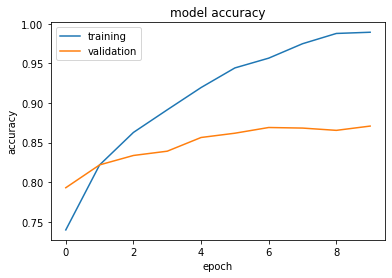

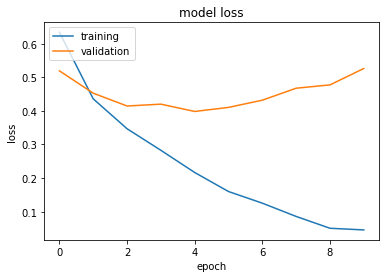

In [51]:
# Model Performance Charts

plt.plot(bi_lstm_model_history.history['acc'])
plt.plot(bi_lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

plt.plot(bi_lstm_model_history.history['loss'])
plt.plot(bi_lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

### **Classification report**

109/109 [==============================] - 9s 76ms/step
              precision    recall  f1-score   support

           0       0.77      0.65      0.71       307
           1       0.85      0.81      0.83      1260
           2       0.90      0.95      0.92      1901

    accuracy                           0.87      3468
   macro avg       0.84      0.80      0.82      3468
weighted avg       0.87      0.87      0.87      3468



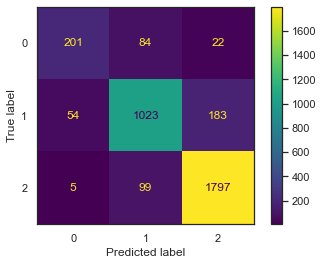

In [52]:
# Classification report test data
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_true=np.argmax(y_test, axis=1)
y_pred_test = bi_lstm_model.predict(X_test)
y_pred_test=np.argmax(y_pred_test, axis=1)
sns.set_theme(style='white')
def class_report(model,y_true,pred):
    print(classification_report(y_true,pred))
    cm = confusion_matrix(y_true,pred,labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
    disp.plot()
    plt.show()


class_report(bi_lstm_model,y_true,y_pred_test) 

# Original mapping
# sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}

# New mapping
# negative --> 0
# neutral --> 1
# positive --> 2

### **ROC Curve**

In [53]:
from sklearn.preprocessing import label_binarize

In [54]:
n_classes = 3

y_nn_auc = label_binarize(y_nn, classes=[0,1,2])

n_classes = y_nn_auc.shape[1]

In [55]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y_nn_auc,test_size=.2,random_state=42, 
                                            stratify=y_nn_auc)

In [56]:
bi_lstm_model = Sequential()
embedding_layer = Embedding(vocab_length,d2v_vector_size,weights=[embedding_matrix],
                                        input_length=max_len,trainable=False)

bi_lstm_model.add(embedding_layer)
bi_lstm_model.add(Bidirectional(LSTM(128)))
bi_lstm_model.add(Dense(3,activation='softmax'))
bi_lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

print(bi_lstm_model.summary())
# Model training

bi_lstm_model_history = bi_lstm_model.fit(
    X_train,y_train,batch_size=128,epochs=10, verbose=1, validation_split=.2
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 400)          2903600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              541696    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 3,446,067
Trainable params: 542,467
Non-trainable params: 2,903,600
_________________________________________________________________
None
Epoch 1/10
87/87 [==============================] - 55s 589ms/step - loss: 0.6398 - acc: 0.7307 - val_loss: 0.5172 - val_acc: 0.7898
Epoch 2/10
87/87 [==============================] - 50s 579ms/step - loss: 0.4336 - acc: 0.8260 - 

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score,auc
fpr = {}
tpr = {}
roc_auc = {}
# Plot linewidth
lw = 2

# Version 2
classes_by_names = ["negative","neutral","positive"]
def roc_curve_plot(value,y_test):
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], 
                                                    value[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])                                                    
        plt.plot(fpr[i], tpr[i], lw=lw, label= "ROC of class {}, AUC= {}"
        .format(classes_by_names[i],np.round(roc_auc[i],2)))
        
       
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="best",frameon=True) # ,labels=["negative","neutral","positive"]
    # Title should be modified
    plt.title("ROC curve of Simple Neural Network multiclass; Sentiment prediction")
    plt.show()
    roc_auc_scoring_macro_ovr = roc_auc_score(y_test,value, multi_class="OvR",average='macro')
    print("AUC macro-averaged over all classes: {:.2f}"
    .format(roc_auc_scoring_macro_ovr))

In [58]:
y_pred_test = bi_lstm_model.predict(X_test)
# y_pred_test=np.argmax(y_pred_test, axis=1)

109/109 [==============================] - 10s 79ms/step


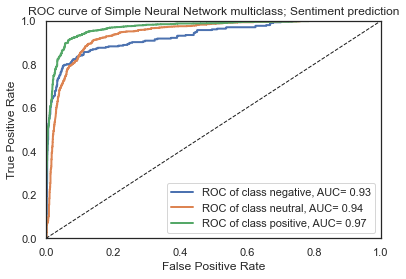

AUC macro-averaged over all classes: 0.95


In [59]:
roc_curve_plot(y_pred_test,y_test)

## **Conclusion**

Using the Bidirectional-LSTM;
- PV-DBOW vector size of 200 had an f1 score of 0.53 and AUC score of 0.87 on test data
- PV-DM vector size of 200 had an f1 score of 0.79 and AUC score of 0.94 on test data
- Combining both methods did in fact improve the model. 


**Table of Values**

dataset|f1_score_macro_avg|AUC_score_avg
| ----------- | ----------- | ----------- |
df_clean (test data)|0.82|0.95